In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from scipy import stats
import time

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'

In [4]:
training_index_start = 0
training_index_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [8]:
def make_scatter(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, do_log_log:bool=False, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [9]:
def make_scatter_with_handle(axs, xvalues:torch.Tensor, yvalues:torch.Tensor, label:str):
    axs.scatter(  depytorch( xvalues.flatten() ), depytorch( yvalues.flatten() ), label=label  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )

In [10]:
def make_errorbar(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, yerrs:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    x_flat = depytorch( xvalues.flatten() )
    y_flat = depytorch( yvalues.flatten() )
    axs.errorbar(  x=x_flat, y=y_flat, yerr=depytorch( yerrs.flatten() ), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.legend()
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [11]:
def make_errorbar_with_handle(axs, xvalues:torch.Tensor, yvalues:torch.Tensor, yerrs:torch.Tensor, label:str):
    axs.errorbar(  x=depytorch( xvalues.flatten() ), y=depytorch( yvalues.flatten() ), yerr=depytorch( yerrs.flatten() ), label=label  )

In [12]:
def make_errorbar_two_sides(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, y_bounds=None, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    y_middle = yvalues[:,1]
    y_low = y_middle - yvalues[:,0]
    y_high = yvalues[:,2] - y_middle
    y_err = torch.stack( (y_low,y_high), dim=0 )
    axs.errorbar(  x=depytorch(xvalues), y=depytorch(y_middle), yerr=depytorch(y_err), color='red', ecolor='blue'  )
    # axs.plot(x_flat, y_flat, color='red', label='mean', linewidth=10, fillstyle='full')
    if type(y_bounds) != type(None):
        axs.set_ylim(y_bounds)
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.legend()
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [13]:
def show_square(values:torch.Tensor, width:int=10, height:int=10):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(width, height) )
    cbax = axs.imshow( depytorch(values) )
    fig.colorbar(cbax, shrink=0.8)

In [14]:
def get_values_for_counts(counts:torch.Tensor):
    return torch.arange( start=1, end=counts.size(dim=-1)+1, dtype=float_type, device=device )

In [15]:
def make_scatter_and_line(xname:str, xvalues:torch.Tensor, yname:str, scatter_label:str, y_scatter_values:torch.Tensor, line_label:str, y_line_values:torch.Tensor, do_log_log:bool=False, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    x_np = depytorch( xvalues.flatten() )
    axs.scatter(  x_np, depytorch( y_scatter_values.flatten() ), label=scatter_label  )
    axs.plot(  x_np, depytorch( y_line_values.flatten() ), label=line_label  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    axs.legend()
    plt.show()
    if save:
        plt.savefig(file_name)

In [16]:
def make_scatter_and_line_2x(xname:str, yname:str, scatter_label:str, x_scatter_values:torch.Tensor, y_scatter_values:torch.Tensor, line_label:str, x_line_values:torch.Tensor, y_line_values:torch.Tensor, do_log_log:bool=False, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter(  depytorch( x_scatter_values.flatten() ), depytorch( y_scatter_values.flatten() ), label=scatter_label  )
    axs.plot(  depytorch( x_line_values.flatten() ), depytorch( y_line_values.flatten() ), label=line_label  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    if do_log_log:
        axs.set_xscale('log')
        axs.set_yscale('log')
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    axs.legend()
    plt.show()
    if save:
        plt.savefig(file_name)

In [17]:
def make_histograms_for_rows(name:str, row_names:list, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    num_hists = values.size(dim=0)
    for row in range(num_hists):
        axs.hist( depytorch(values[row,:]), label=row_names[row] )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.legend()
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [17]:
# First, show how the choice of binarization threshold affects avalanche criticality in the data.
num_thresholds = 1001
min_threshold = 0.0
max_threshold = 4.0
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
data_file_fragment = f'all_thresholds_{num_thresholds}_from_{min_threshold:.3g}_to_{max_threshold:.3g}_passes_1000_tries_1000_pvalsamples_10000'

In [18]:
avalanche_duration_file_fragment = f'avalanche_duration_{data_file_fragment}'
avalanche_size_file_fragment = f'avalanche_size_{data_file_fragment}'
mean_size_file_fragment = f'mean_size_for_duration_{data_file_fragment}'

duration exponent size torch.Size([1001])
size exponent size torch.Size([1001])


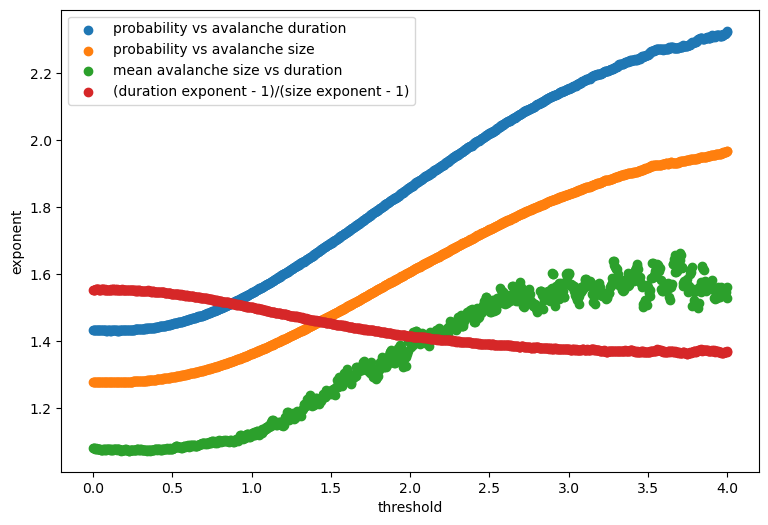

In [97]:
duration_exponent_file = os.path.join(file_dir, f'best_exponent_{avalanche_duration_file_fragment}.pt')
duration_exponent = torch.load(duration_exponent_file)
print( 'duration exponent size', duration_exponent.size() )
size_exponent_file = os.path.join(file_dir, f'best_exponent_{avalanche_size_file_fragment}.pt')
size_exponent = torch.load(size_exponent_file)
print( 'size exponent size', size_exponent.size() )
mean_size_exponent_file = os.path.join(file_dir, f'exponent_{mean_size_file_fragment}.pt')
mean_size_exponent = torch.load(mean_size_exponent_file)
criticality_factor = (duration_exponent-1)/(size_exponent-1)

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=duration_exponent, label='probability vs avalanche duration')
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=size_exponent, label='probability vs avalanche size')
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=mean_size_exponent, label='mean avalanche size vs duration')
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=criticality_factor, label='(duration exponent - 1)/(size exponent - 1)')
axs.legend()
axs.set_xlabel('threshold')
axs.set_ylabel('exponent')
plt.show()

In [98]:
diff_from_critical = torch.abs(criticality_factor - mean_size_exponent)
min_diff_index = torch.argmin(diff_from_critical)
closest_to_critical_threshold = thresholds[min_diff_index]
print(f'Avalanche behavior comes closest to critical point at threshold {closest_to_critical_threshold:.3g}, diff {diff_from_critical[min_diff_index]:.3g}, duration exponent {duration_exponent[min_diff_index]:.3g}, size exponent {size_exponent[min_diff_index]:.3g}, mean size for duration exponent {mean_size_exponent[min_diff_index]:.3g}.')

Avalanche behavior comes closest to critical point at threshold 2.1, diff 0.00165, duration exponent 1.89, size exponent 1.63, mean size for duration exponent 1.41.


duration log likelihood size torch.Size([1001])
size log likelihood size torch.Size([1001])


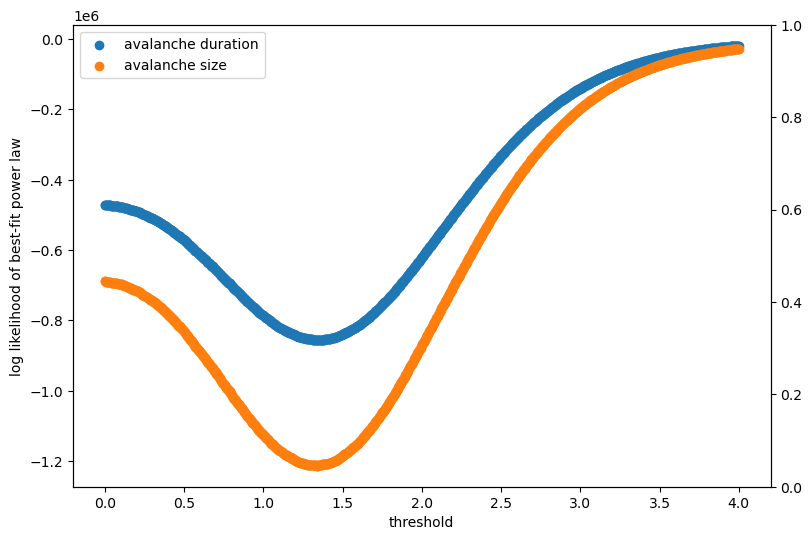

In [99]:
duration_log_likelihood_file = os.path.join(file_dir, f'best_log_likelihood_{avalanche_duration_file_fragment}.pt')
duration_log_likelihood = torch.load(duration_log_likelihood_file)
print( 'duration log likelihood size', duration_log_likelihood.size() )
size_log_likelihood_file = os.path.join(file_dir, f'best_log_likelihood_{avalanche_size_file_fragment}.pt')
size_log_likelihood = torch.load(size_log_likelihood_file)
print( 'size log likelihood size', size_log_likelihood.size() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs2 = axs.twinx()
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=duration_log_likelihood, label='avalanche duration')
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=size_log_likelihood, label='avalanche size')

axs.legend()
# axs2.legend()
axs.set_xlabel('threshold')
axs.set_ylabel('log likelihood of best-fit power law')
# axs2.set_ylabel('probability of data sampled from power law having greater KS distance')
plt.show()

duration KS distance size torch.Size([1001])
size KS distance size torch.Size([1001])


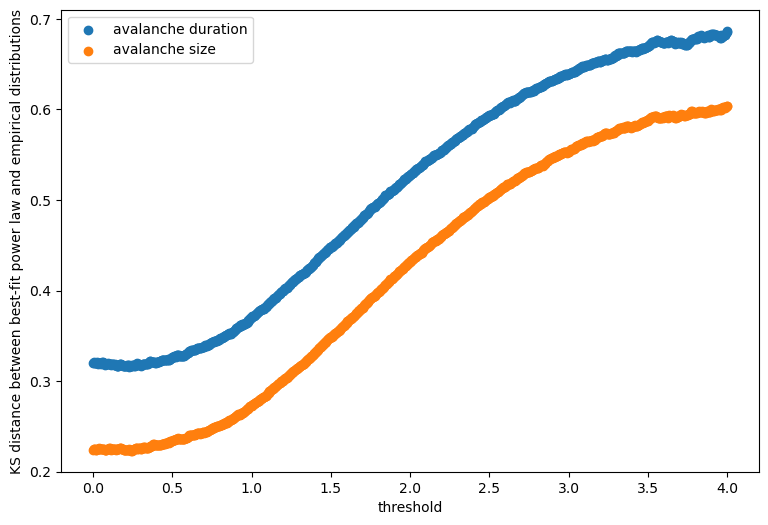

In [100]:
duration_ks_distance_file = os.path.join(file_dir, f'ks_distance_{avalanche_duration_file_fragment}.pt')
duration_ks_distance = torch.load(duration_ks_distance_file)
print( 'duration KS distance size', duration_ks_distance.size() )
size_ks_distance_file = os.path.join(file_dir, f'ks_distance_{avalanche_size_file_fragment}.pt')
size_ks_distance = torch.load(size_ks_distance_file)
print( 'size KS distance size', size_ks_distance.size() )

# duration_p_value_file = os.path.join(file_dir, f'p_value_{avalanche_duration_file_fragment}.pt')
# duration_p_value = torch.load(duration_p_value_file)
# print( 'duration p-value size', duration_p_value.size() )
# size_p_value_file = os.path.join(file_dir, f'p_value_{avalanche_size_file_fragment}.pt')
# size_p_value = torch.load(size_p_value_file)
# print( 'size p-value size', size_p_value.size() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
# axs2 = axs.twinx()
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=duration_ks_distance, label='avalanche duration')
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=size_ks_distance, label='avalanche size')

# make_scatter_with_handle(axs=axs2, xvalues=thresholds, yvalues=duration_p_value, label='avalanche duration p-value')
# make_scatter_with_handle(axs=axs2, xvalues=thresholds, yvalues=size_p_value, label='avalanche size p-value')
axs.legend()
# axs2.legend()
axs.set_xlabel('threshold')
axs.set_ylabel('KS distance between best-fit power law and empirical distributions')
# axs2.set_ylabel('probability of data sampled from power law having greater KS distance')
plt.show()

mean size for distance R^2 size torch.Size([1001])


Text(0, 0.5, 'coefficient of determination of best-fit mean size  power law')

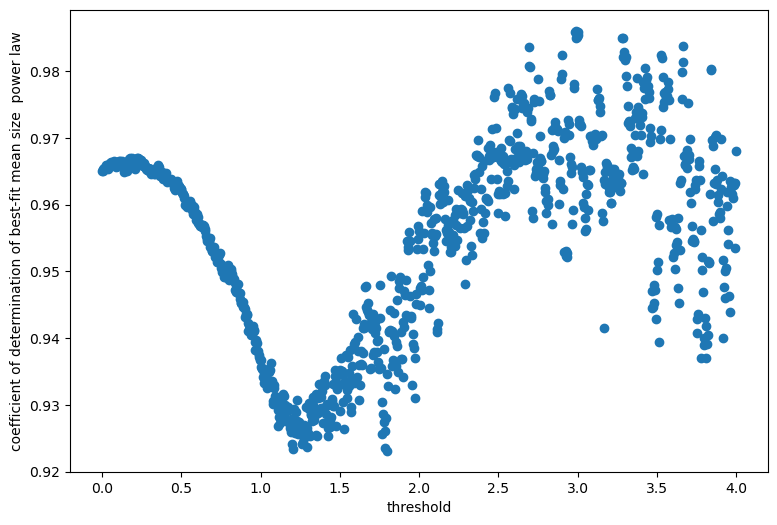

In [101]:
mean_size_r_squared_file = os.path.join(file_dir, f'r_squared_{mean_size_file_fragment}.pt')
mean_size_r_squared = torch.load(mean_size_r_squared_file)
print( 'mean size for distance R^2 size', mean_size_r_squared.size() )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=thresholds, yvalues=mean_size_r_squared, label='R^2 of mean size for duration')
axs.set_xlabel('threshold')
axs.set_ylabel('coefficient of determination of best-fit mean size  power law')

In [104]:
target_threshold = 1.0# closest_to_critical_threshold
threshold_index = torch.argmin( torch.abs(thresholds-target_threshold) )
threshold = thresholds[threshold_index]
print(f'closest threshold to {target_threshold:.3g} is {threshold:.3g} at index {threshold_index}')

closest threshold to 1 is 1 at index 250


In [105]:
duration_counts_file = os.path.join(file_dir, f'duration_counts_{data_file_fragment}.pt')
duration_counts = torch.load(duration_counts_file)
print( 'duration counts size', duration_counts.size() )
duration_probs = duration_counts/duration_counts.sum(dim=-1, keepdim=True)

duration_exponent_file = os.path.join(file_dir, f'best_exponent_{avalanche_duration_file_fragment}.pt')
duration_exponent = torch.load(duration_exponent_file)
print( 'duration exponent size', duration_exponent.size() )

duration_ks_distance_file = os.path.join(file_dir, f'ks_distance_{avalanche_duration_file_fragment}.pt')
duration_ks_distance = torch.load(duration_ks_distance_file)
print( 'duration KS distance size', duration_ks_distance.size() )

num_durations = duration_counts.size(dim=-1)
durations = torch.arange(start=1, end=num_durations+1, dtype=float_type, device=device)

duration counts size torch.Size([1001, 1187])
duration exponent size torch.Size([1001])
duration KS distance size torch.Size([1001])


Text(0, 0.5, 'probability')

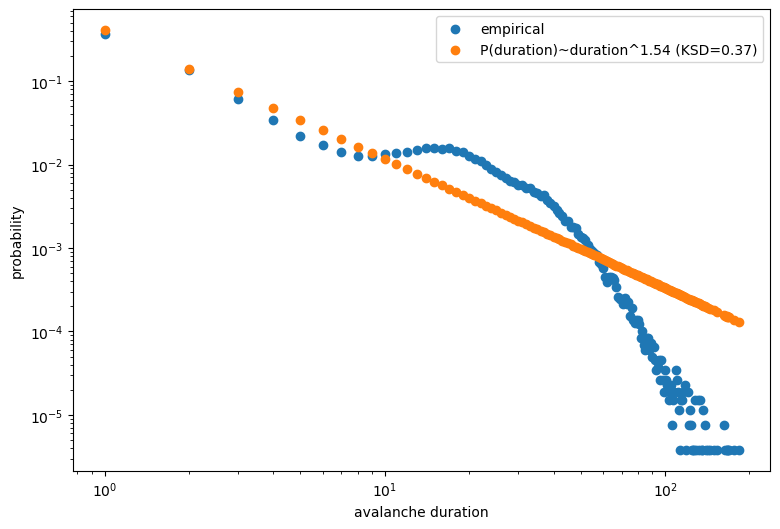

In [106]:
duration_counts_at_thresh = duration_counts[threshold_index,:]
duration_exponent_at_thresh = duration_exponent[threshold_index]
duration_ks_distance_at_thresh = duration_ks_distance[threshold_index]

has_duration = duration_counts_at_thresh > 0
durations_nz = durations[has_duration]
duration_probs_nz = duration_probs[threshold_index,has_duration]
predicted_duration_probs_nz = torch.pow(durations_nz, -duration_exponent_at_thresh)/torch.special.zeta(duration_exponent_at_thresh, 1.0)

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )

make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=duration_probs_nz, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=predicted_duration_probs_nz, label=f'P(duration)~duration^{duration_exponent_at_thresh:.3g} (KSD={duration_ks_distance_at_thresh:.3g})')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche duration')
axs.set_ylabel('probability')

In [107]:
size_counts_file = os.path.join(file_dir, f'size_counts_{data_file_fragment}.pt')
size_counts = torch.load(size_counts_file)
print( 'size counts size', size_counts.size() )
size_probs = size_counts/size_counts.sum(dim=-1, keepdim=True)

size_exponent_file = os.path.join(file_dir, f'best_exponent_{avalanche_size_file_fragment}.pt')
size_exponent = torch.load(size_exponent_file)
print( 'size exponent size', size_exponent.size() )

size_ks_distance_file = os.path.join(file_dir, f'ks_distance_{avalanche_size_file_fragment}.pt')
size_ks_distance = torch.load(size_ks_distance_file)
print( 'size KS distance size', size_ks_distance.size() )

num_sizes = size_counts.size(dim=-1)
sizes = torch.arange(start=1, end=num_sizes+1, dtype=float_type, device=device)

size counts size torch.Size([1001, 12253])
size exponent size torch.Size([1001])
size KS distance size torch.Size([1001])


Text(0, 0.5, 'probability')

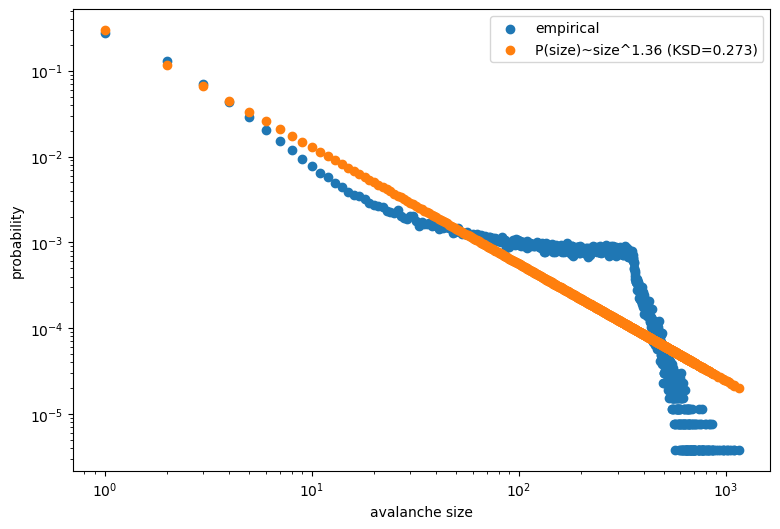

In [108]:
size_counts_at_thresh = size_counts[threshold_index,:]
size_exponent_at_thresh = size_exponent[threshold_index]
size_ks_distance_at_thresh = size_ks_distance[threshold_index]

has_size = size_counts_at_thresh > 0
sizes_nz = sizes[has_size]
size_probs_nz = size_probs[threshold_index,has_size]
predicted_size_probs_nz = torch.pow(sizes_nz, -size_exponent_at_thresh)/torch.special.zeta(size_exponent_at_thresh, 1.0)

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )

make_scatter_with_handle(axs=axs, xvalues=sizes_nz, yvalues=size_probs_nz, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=sizes_nz, yvalues=predicted_size_probs_nz, label=f'P(size)~size^{size_exponent_at_thresh:.3g} (KSD={size_ks_distance_at_thresh:.3g})')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche size')
axs.set_ylabel('probability')

In [109]:
mean_size_for_duration_file = os.path.join(file_dir, f'{mean_size_file_fragment}.pt')
mean_size_for_duration = torch.load(mean_size_for_duration_file)
print( 'mean size for duration size', mean_size_for_duration.size() )

r_squared_file = os.path.join(file_dir, f'r_squared_{mean_size_file_fragment}.pt')
r_squared = torch.load(r_squared_file)
print( 'mean size for duration R^2 size', r_squared.size() )

mean_size_exponent_file = os.path.join(file_dir, f'exponent_{mean_size_file_fragment}.pt')
mean_size_exponent = torch.load(mean_size_exponent_file)
print( 'mean size for duration exponent size', mean_size_exponent.size() )

scale_factor_file = os.path.join(file_dir, f'scale_factor_{mean_size_file_fragment}.pt')
scale_factor = torch.load(scale_factor_file)
print( 'mean size for duration scale factor size', scale_factor.size() )

num_durations = mean_size_for_duration.size(dim=-1)
durations = torch.arange(start=1, end=num_durations+1, dtype=float_type, device=device)

mean size for duration size torch.Size([1001, 1187])
mean size for duration R^2 size torch.Size([1001])
mean size for duration exponent size torch.Size([1001])
mean size for duration scale factor size torch.Size([1001])


Text(0, 0.5, 'mean avalanche size')

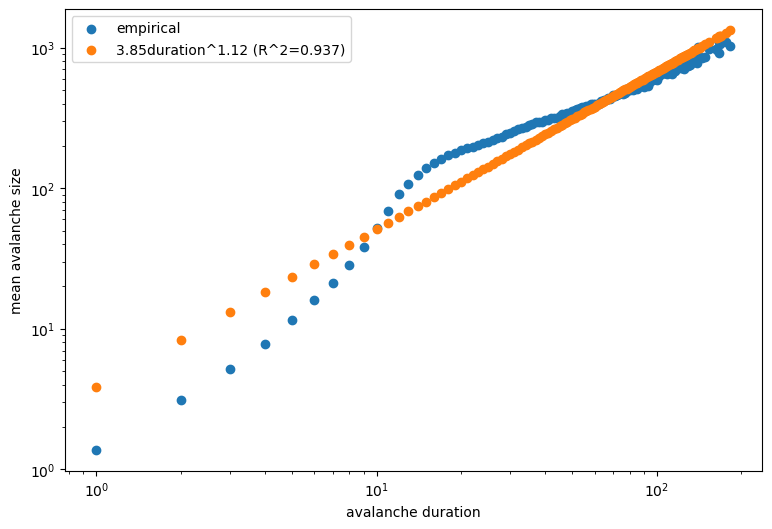

In [110]:
mean_size_for_duration_at_thresh = mean_size_for_duration[threshold_index,:]
scale_factor_at_thresh = scale_factor[threshold_index].exp()
mean_size_exponent_at_thresh = mean_size_exponent[threshold_index]
r_squared_at_thresh = r_squared[threshold_index]

has_mean_size = mean_size_for_duration_at_thresh > 0
durations_nz = durations[has_mean_size]
mean_size_for_duration_nz = mean_size_for_duration_at_thresh[has_mean_size]
mean_size_for_duration_predicted = scale_factor_at_thresh*torch.pow(durations_nz,mean_size_exponent_at_thresh)
# log_mean_size_for_duration_predicted = scale_factor_at_thresh+mean_size_exponent_at_thresh*durations_nz.log()
# mean_size_for_duration_predicted = log_mean_size_for_duration_predicted.exp()

# log_durations = durations_nz.log()
# log_mean_size_for_duration = mean_size_for_duration_nz.log()

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=mean_size_for_duration_nz, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=mean_size_for_duration_predicted, label=f'{scale_factor_at_thresh:.3g}duration^{mean_size_exponent_at_thresh:.3g} (R^2={r_squared_at_thresh:.3g})')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche duration')
axs.set_ylabel('mean avalanche size')

In [111]:
threshold_index
diff_from_critical = torch.abs(criticality_factor - mean_size_exponent)
min_diff_index = torch.argmin(diff_from_critical)
closest_to_critical_threshold = thresholds[min_diff_index]
signed_diff_from_crit_at_threshold = (duration_exponent[threshold_index]-1)/(size_exponent[threshold_index]-1) - mean_size_exponent[threshold_index]
print(f'(duration_exponent-1)/(size_exponent-1) - mean_size_for_duration_exponent = ({duration_exponent[threshold_index]:.3g}-1)/({size_exponent[threshold_index]:.3g}-1) - {mean_size_exponent[threshold_index]:.3g} = {signed_diff_from_crit_at_threshold:.3g}')

(duration_exponent-1)/(size_exponent-1) - mean_size_for_duration_exponent = (1.54-1)/(1.36-1) - 1.12 = 0.378


In [19]:
# Now look at results for an Ising model simulation for data binarized at the mean.
duration_exponent = 1.46
size_exponent = 1.33
mean_size_exponent = 1.18
mean_size_scale_factor = -11.7
data_file_fragment = 'all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_betatimes_1.95_steps_1200'

In [63]:
# Now look at results for an Ising model simulation for data binarized at mean + 1SD.
duration_exponent = 1.46
size_exponent = 1.32
mean_size_exponent = 1.13
mean_size_scale_factor = -9.69
data_file_fragment = 'all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_betatimes_5.56_steps_1200'

In [20]:
avalanche_duration_count_file = os.path.join(file_dir, f'avalanche_duration_count_{data_file_fragment}.pt')
avalanche_duration_count = torch.load(avalanche_duration_count_file)
print( 'avalanche_duration_count size', avalanche_duration_count.size() )

num_durations = avalanche_duration_count.size(dim=-1)
durations = torch.arange(start=1, end=num_durations+1, dtype=float_type, device=device)
avalanche_duration_probs = avalanche_duration_count/avalanche_duration_count.sum(dim=-1, keepdim=True)
duration_zeta = torch.special.zeta( duration_exponent, torch.ones_like(durations) )
avalanche_duration_probs_predicted = torch.pow(durations, -duration_exponent)/duration_zeta
avalanche_duration_cdf = torch.cumsum(avalanche_duration_probs, dim=-1)
avalanche_duration_cdf_predicted = 1 - torch.special.zeta(duration_exponent, durations)/duration_zeta
avalanche_duration_ks_dist = torch.max( torch.abs(avalanche_duration_cdf - avalanche_duration_cdf_predicted) )

duration_count_is_nz = avalanche_duration_count > 0
durations_nz = durations[duration_count_is_nz]
avalanche_duration_probs_nz = avalanche_duration_probs[duration_count_is_nz]
avalanche_duration_probs_predicted_nz = avalanche_duration_probs_predicted[duration_count_is_nz]

avalanche_duration_count size torch.Size([1199])


Text(0, 0.5, 'probability')

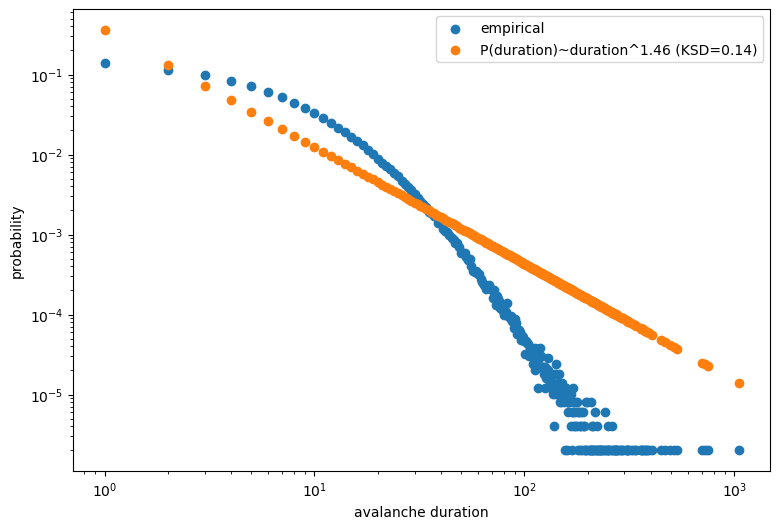

In [21]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=avalanche_duration_probs_nz, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=avalanche_duration_probs_predicted_nz, label=f'P(duration)~duration^{duration_exponent:.3g} (KSD={avalanche_duration_ks_dist:.3g})')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche duration')
axs.set_ylabel('probability')

Text(0, 0.5, 'CDF')

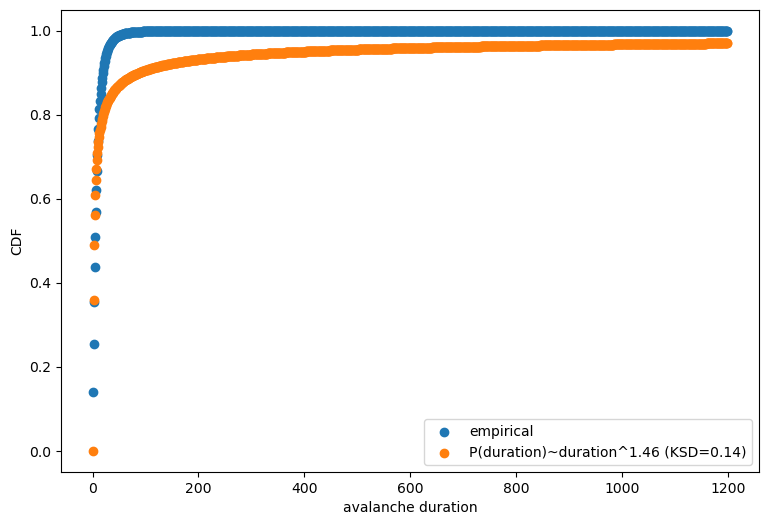

In [22]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=durations, yvalues=avalanche_duration_cdf, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=durations, yvalues=avalanche_duration_cdf_predicted, label=f'P(duration)~duration^{duration_exponent:.3g} (KSD={avalanche_duration_ks_dist:.3g})')

# axs.set_xscale('log')
# axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche duration')
axs.set_ylabel('CDF')

In [23]:
avalanche_size_count_file = os.path.join(file_dir, f'avalanche_size_count_{data_file_fragment}.pt')
avalanche_size_count = torch.load(avalanche_size_count_file)
print( 'avalanche_size_count size', avalanche_size_count.size() )

num_sizes = avalanche_size_count.size(dim=-1)
sizes = torch.arange(start=1, end=num_sizes+1, dtype=float_type, device=device)
avalanche_size_probs = avalanche_size_count/avalanche_size_count.sum(dim=-1, keepdim=True)
size_zeta = torch.special.zeta( size_exponent, torch.ones_like(sizes) )
avalanche_size_probs_predicted = torch.pow(sizes, -size_exponent)/size_zeta
avalanche_size_cdf = torch.cumsum(avalanche_size_probs, dim=-1)
avalanche_size_cdf_predicted = 1 - torch.special.zeta(size_exponent, sizes)/size_zeta
avalanche_size_ks_dist = torch.max( torch.abs(avalanche_size_cdf - avalanche_size_cdf_predicted) )

size_count_is_nz = avalanche_size_count > 0
sizes_nz = sizes[size_count_is_nz]
avalanche_size_probs_nz = avalanche_size_probs[size_count_is_nz]
avalanche_size_probs_predicted_nz = avalanche_size_probs_predicted[size_count_is_nz]

avalanche_size_count size torch.Size([431640])


Text(0, 0.5, 'probability')

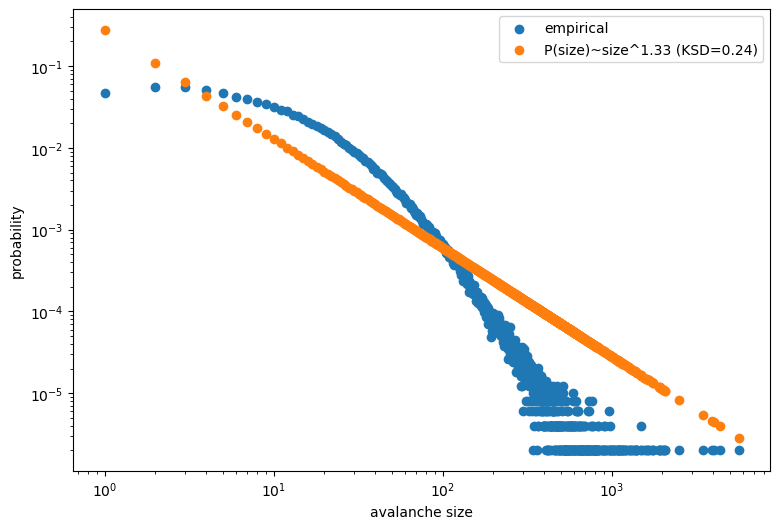

In [24]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=sizes_nz, yvalues=avalanche_size_probs_nz, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=sizes_nz, yvalues=avalanche_size_probs_predicted_nz, label=f'P(size)~size^{size_exponent:.3g} (KSD={avalanche_size_ks_dist:.3g})')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche size')
axs.set_ylabel('probability')

Text(0, 0.5, 'CDF')

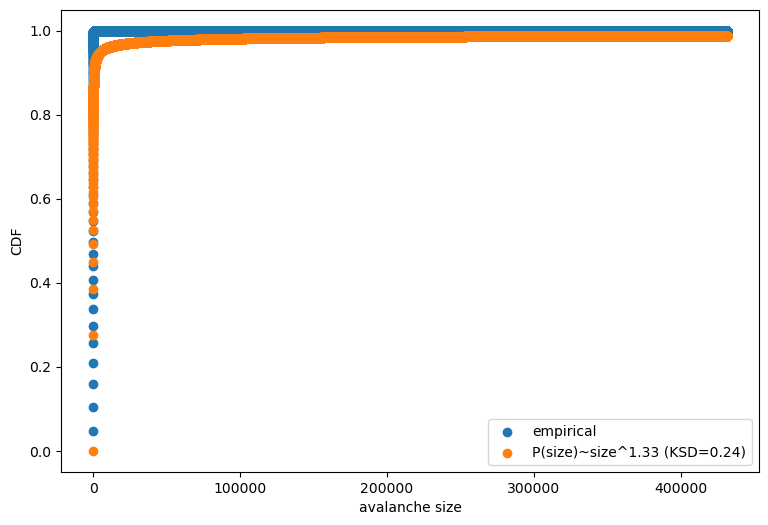

In [25]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=sizes, yvalues=avalanche_size_cdf, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=sizes, yvalues=avalanche_size_cdf_predicted, label=f'P(size)~size^{size_exponent:.3g} (KSD={avalanche_size_ks_dist:.3g})')

# axs.set_xscale('log')
# axs.set_yscale('log')
axs.legend()
axs.set_xlabel('avalanche size')
axs.set_ylabel('CDF')

In [26]:
mean_size_for_duration_file = os.path.join(file_dir, f'avalanche_mean_size_for_duration_{data_file_fragment}.pt')
mean_size_for_duration = torch.load(mean_size_for_duration_file)
print( 'mean_size_for_duration size', mean_size_for_duration.size() )

mean_size_for_duration size torch.Size([1199])


In [27]:
def fit_power_law_lstsq(mean_sizes:torch.Tensor):
    max_value = mean_sizes.numel()
    values = torch.arange(start=1, end=max_value+1, dtype=float_type, device=mean_sizes.device)
    is_gt_0 = mean_sizes > 0
    mean_sizes = mean_sizes[is_gt_0]
    values = values[is_gt_0]
    log_values_with_1s = torch.stack(  ( values.log(), torch.ones_like(values) ), dim=-1  )
    log_mean_sizes = torch.log( mean_sizes ).unsqueeze(dim=-1)
    coeffs = torch.linalg.lstsq(log_values_with_1s, log_mean_sizes).solution
    r_squared = 1 - torch.sum(  torch.square( log_mean_sizes - torch.matmul(log_values_with_1s, coeffs) )  )/torch.sum(  torch.square( log_mean_sizes - torch.mean(log_mean_sizes) )  )
    coeffs_flat = torch.flatten(coeffs)
    exponent = coeffs_flat[0]
    scale_factor = coeffs_flat[1]
    print(f'fitted power law with least squares: log(<S>) = {exponent:.3g}log(T) + {scale_factor:.3g}, R^2 = {r_squared:.3g}')
    return exponent, scale_factor, r_squared

In [28]:
mean_size_exponent, mean_size_scale_factor, r_squared = fit_power_law_lstsq(mean_size_for_duration)

fitted power law with least squares: log(<S>) = 1.18log(T) + 0.47, R^2 = 0.995


In [29]:
num_durations = mean_size_for_duration.size(dim=-1)
durations = torch.arange(start=1, end=num_durations+1, dtype=float_type, device=device)
exp_mean_size_scale_factor = math.exp(mean_size_scale_factor)
mean_size_for_duration_predicted = exp_mean_size_scale_factor * torch.pow(durations, mean_size_exponent)
mean_size_for_duration_predicted = torch.exp( mean_size_scale_factor + mean_size_exponent*torch.log(durations) )

mean_size_for_duration_is_nz = mean_size_for_duration > 0
durations_nz = durations[mean_size_for_duration_is_nz]
mean_size_for_duration_nz = mean_size_for_duration[mean_size_for_duration_is_nz]
mean_size_for_duration_predicted_nz = mean_size_for_duration_predicted[mean_size_for_duration_is_nz]

Text(0, 0.5, 'mean size')

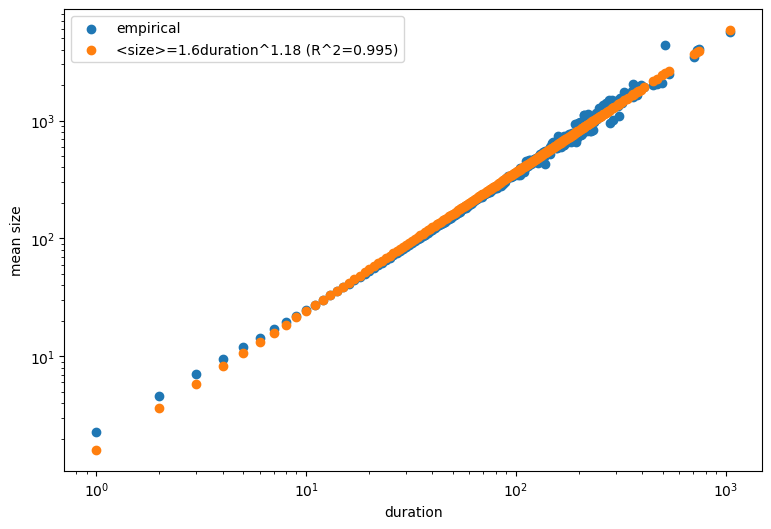

In [30]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=mean_size_for_duration_nz, label='empirical')
make_scatter_with_handle(axs=axs, xvalues=durations_nz, yvalues=mean_size_for_duration_predicted_nz, label=f'<size>={exp_mean_size_scale_factor:.3g}duration^{mean_size_exponent:.3g} (R^2={r_squared:.3g})')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend()
axs.set_xlabel('duration')
axs.set_ylabel('mean size')

In [21]:
# probs = torch.tensor(data=[0.0, 0.2, 0.2, 0.2, 0.2, 0.2], dtype=float_type, device=device)
num_durations = 120000
num_samples = 10000
durations = torch.arange(1, num_durations+1, dtype=float_type, device=device)
probs = torch.pow( durations, -1.5 )
probs /= probs.sum()
print( 'probs', probs )
probs_cs = torch.cumsum(probs, dim=0)
cdf = probs_cs/probs_cs[-1]
# print( 'cdf', cdf )
samples = torch.rand( size=(1,num_samples), dtype=float_type, device=device )
# print( 'samples', samples )
cdf_with_zero = torch.zeros( size=(num_durations+1,1), dtype=float_type, device=device )
cdf_with_zero[1:,0] = cdf
bin_mat = torch.diff( cdf_with_zero >= samples, dim=0 )
# print( 'bin_mat', bin_mat )
bin_count = torch.sum(bin_mat, dim=1)
# print( 'bin_count', bin_count )
empirical_probs = bin_count/torch.sum(bin_count)
print( 'empirical_probs', empirical_probs )
empirical_cdf = torch.cumsum(empirical_probs, dim=0)
ks_dist = torch.max( torch.abs(empirical_cdf - cdf) )
print(f'KS distance {ks_dist:.3g}')
make_scatter_and_line(xname='durations', xvalues=durations, yname='probabilities', scatter_label='empirical', y_scatter_values=empirical_probs, line_label='true', y_line_values=probs, do_log_log=True)

probs tensor([3.8364e-01, 1.3564e-01, 7.3832e-02,  ..., 9.2292e-09, 9.2291e-09,
        9.2290e-09], device='cuda:0')


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.94 GiB (GPU 0; 8.00 GiB total capacity; 1.12 GiB already allocated; 0 bytes free; 8.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
num_values = 10
values = torch.arange(start=1, end=num_values+1, dtype=float_type, device=device)
print(values)
x_bounds = torch.triu_indices(row=num_values+1, col=num_values+1, offset=3)
x_start = x_bounds[0]
x_end = x_bounds[1]
for bounds_index in range( x_start.numel() ):
    print(values[ x_start[bounds_index]:x_end[bounds_index] ])

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], device='cuda:0')
tensor([1., 2., 3.], device='cuda:0')
tensor([1., 2., 3., 4.], device='cuda:0')
tensor([1., 2., 3., 4., 5.], device='cuda:0')
tensor([1., 2., 3., 4., 5., 6.], device='cuda:0')
tensor([1., 2., 3., 4., 5., 6., 7.], device='cuda:0')
tensor([1., 2., 3., 4., 5., 6., 7., 8.], device='cuda:0')
tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.], device='cuda:0')
tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], device='cuda:0')
tensor([2., 3., 4.], device='cuda:0')
tensor([2., 3., 4., 5.], device='cuda:0')
tensor([2., 3., 4., 5., 6.], device='cuda:0')
tensor([2., 3., 4., 5., 6., 7.], device='cuda:0')
tensor([2., 3., 4., 5., 6., 7., 8.], device='cuda:0')
tensor([2., 3., 4., 5., 6., 7., 8., 9.], device='cuda:0')
tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], device='cuda:0')
tensor([3., 4., 5.], device='cuda:0')
tensor([3., 4., 5., 6.], device='cuda:0')
tensor([3., 4., 5., 6., 7.], device='cuda:0')
tensor([3., 4

In [20]:
num_ranges = x_start.numel()
is_in_range = torch.zeros( size=(num_ranges,num_values), dtype=torch.bool, device=device )
for x_index in range(num_values):
    is_in_range[:,x_index] = torch.logical_and(x_start <= x_index, x_index < x_end)
print(is_in_range)

tensor([[ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True, False, False, False, False, False, False],
        [False,  True,  True,  True,  True, False, False, False, False, False],
        [False,  True,  True,  True,  True,  True, False, False, False, False],
        [False,  True,  True,  True,  True,  True,  True, False, False, False],
        [False,  True,  True,  True,  Tr

In [18]:
num_thresholds = 5
min_threshold = 0
max_threshold = 4
value_name = 'duration'
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
param_string = f'training_thresholds_{num_thresholds}_from_{min_threshold:.3g}_to_{max_threshold:.3g}_min_interval_3_exponents_from_1_to_10_passes_10_tries_1000_pvalsamples_100'
count_string = f'{value_name}_counts_{param_string}'
power_law_string = f'avalanche_{value_name}_{param_string}'

In [19]:
counts = torch.load( os.path.join(file_dir, f'{count_string}.pt') )
print( counts.size() )

torch.Size([5, 947])


In [20]:
num_thresholds, num_values = counts.size()
values = torch.arange(start=1, end=num_values+1, dtype=counts.dtype, device=counts.device)

In [21]:
def get_interval_endpoints(num_values:int, device:str, min_interval_length:int=3):
    num_values_plus_1 = num_values+1
    value_bounds = torch.triu_indices(row=num_values_plus_1, col=num_values_plus_1, offset=min_interval_length, dtype=int_type, device=device)
    values_start = value_bounds[0]
    values_end = value_bounds[1]
    return values_start, values_end
interval_starts, interval_ends = get_interval_endpoints(num_values=num_values, device=device)
num_intervals = interval_starts.numel()
print( num_intervals )

446985


In [23]:
exponents = torch.load( os.path.join(file_dir, f'exponent_{power_law_string}.pt') )
print( exponents.size() )
# fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(100, 100) )
# cbax = axs.imshow( depytorch(exponents) )
# fig.colorbar(cbax, shrink=0.8)

torch.Size([5, 446985])


In [24]:
log_likelihoods = torch.load( os.path.join(file_dir, f'log_likelihood_{power_law_string}.pt') )
print( log_likelihoods.size() )

torch.Size([5, 446985])


In [25]:
ks_distances = torch.load( os.path.join(file_dir, f'ks_distance_{power_law_string}.pt') )
print( ks_distances.size() )

torch.Size([5, 446985])


In [26]:
p_values = torch.load( os.path.join(file_dir, f'p_value_{power_law_string}.pt') )
print( p_values.size() )

torch.Size([5, 446985])


In [27]:
best_p_value, best_p_value_index = torch.max(p_values, dim=-1)
print('threshold\tinterval\texponent\tlog likelihood\tKS distance\tp-value')
for threshold_index in range( best_p_value_index.numel() ):
    interval_index = best_p_value_index[threshold_index]
    start_index = interval_starts[interval_index]
    end_index = interval_ends[interval_index]
    start_value = values[start_index]
    end_value = values[end_index-1]
    print(f'{thresholds[threshold_index]:.3g}\t[{start_value:.3g},{end_value:.3g}]\t{exponents[threshold_index,interval_index]:.3g}\t{log_likelihoods[threshold_index,interval_index]:.3g}\t{ks_distances[threshold_index,interval_index]:.3g}\t{p_values[threshold_index,interval_index]:.3g}')

threshold	interval	exponent	log likelihood	KS distance	p-value
0	[5,7]	2.91	-1.02	3.92e-05	1
1	[20,22]	1.5	-1.1	0.000345	1
2	[15,17]	2.99	-1.09	0.00112	1
3	[4,6]	1.17	-1.08	0.00105	1
4	[6,8]	3.35	-1.02	0.000471	1


In [28]:
longest_interval_index = torch.argmax(interval_ends - interval_starts)
interval_index = longest_interval_index
start_index = interval_starts[interval_index]
end_index = interval_ends[interval_index]
start_value = values[start_index]
end_value = values[end_index-1]
print('threshold\tinterval\texponent\tlog likelihood\tKS distance\tp-value')
for threshold_index in range( best_p_value_index.numel() ):
    print(f'{thresholds[threshold_index]:.3g}\t[{start_value:.3g},{end_value:.3g}]\t{exponents[threshold_index,interval_index]:.3g}\t{log_likelihoods[threshold_index,interval_index]:.3g}\t{ks_distances[threshold_index,interval_index]:.3g}\t{p_values[threshold_index,interval_index]:.3g}')

threshold	interval	exponent	log likelihood	KS distance	p-value
0	[1,947]	1.33	-3.6	0.121	0
1	[1,947]	1.49	-2.96	0.087	0
2	[1,947]	1.85	-1.92	0.039	0
3	[1,947]	2.15	-1.4	0.0235	0
4	[1,947]	2.33	-1.18	0.0236	0


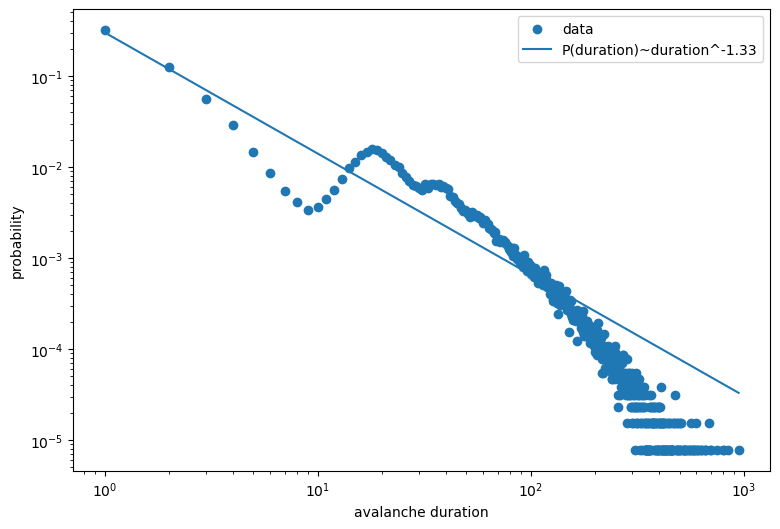

In [40]:
threshold_index = 0
interval_index = longest_interval_index
# interval_index = best_p_value_index[threshold_index]
values_in_range = values[interval_starts[interval_index]:interval_ends[interval_index]]
counts_for_threshold = counts[threshold_index,:]
data_probs = counts_for_threshold/counts_for_threshold.sum()
exponent_for_pair = -exponents[threshold_index,interval_index]
pl_counts = torch.pow(values_in_range, exponent_for_pair)
pl_probs = pl_counts/pl_counts.sum()
make_scatter_and_line_2x(xname=f'avalanche {value_name}', yname='probability', scatter_label='data', x_scatter_values=values, y_scatter_values=data_probs, line_label=f'P({value_name})~{value_name}^{exponent_for_pair:.3g}', x_line_values=values_in_range, y_line_values=pl_probs, do_log_log=True)

threshold 1
interval index 944, KS distance 0.087
interval [1, 947]
total count 2.64e+05
mean log 1.35
pass 1, exponent range [0, 10], log likelihood range [-13.5, -2.96], best exponent 1.49 and log likelihood -2.96
pass 2, exponent range [1.48, 1.5], log likelihood range [-2.96, -2.96], best exponent 1.49 and log likelihood -2.96
pass 3, exponent range [1.49, 1.49], log likelihood range [-2.96, -2.96], best exponent 1.49 and log likelihood -2.96
range has narrowed to 0, so stopping


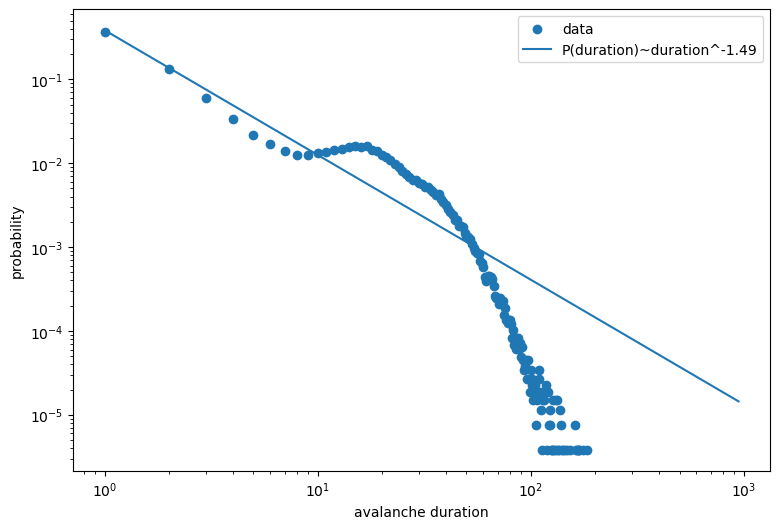

In [49]:
threshold_index = 1
print(f'threshold {thresholds[threshold_index]:.3g}')
interval_index = longest_interval_index
# interval_index = 5
# interval_index = best_p_value_index[threshold_index]
# from_beginning_end = torch.nonzero(interval_starts == 0)[-1]+1
# best_from_beginning_index = torch.argmin(ks_distances[threshold_index,:from_beginning_end])
# interval_index = best_from_beginning_index
print(f'interval index {interval_index}, KS distance {ks_distances[threshold_index,interval_index]:.3g}')
interval_start = interval_starts[interval_index]
interval_end = interval_ends[interval_index]
values_in_range = values[interval_start:interval_end]
print(f'interval [{values_in_range.min():.3g}, {values_in_range.max():.3g}]')
counts_for_threshold = counts[threshold_index,:]
counts_in_range = counts_for_threshold[interval_start:interval_end]
print(f'total count {counts_in_range.sum():.3g}')
mean_log = torch.sum( counts_in_range * torch.log(values_in_range) )/torch.sum(counts_in_range)
print(f'mean log {mean_log:.3g}')
min_exponent = 0
max_exponent = 10
tries_per_pass = 1000
for pass_index in range(10):
    try_exponents = torch.linspace(start=min_exponent, end=max_exponent, steps=tries_per_pass, dtype=float_type, device=device)
    try_log_likelihoods = -torch.log( torch.sum( torch.pow( values_in_range.unsqueeze(dim=0), -try_exponents.unsqueeze(dim=1) ), dim=1 ) ) - try_exponents * mean_log
    max_ll_index = torch.argmax(try_log_likelihoods)
    print(f'pass {pass_index+1}, exponent range [{min_exponent:.3g}, {max_exponent:.3g}], log likelihood range [{try_log_likelihoods.min():.3g}, {try_log_likelihoods.max():.3g}], best exponent {try_exponents[max_ll_index]:.3g} and log likelihood {try_log_likelihoods[max_ll_index]:.3g}')
    min_index = max( max_ll_index-1, 0 )
    max_index = min( max_ll_index+1, tries_per_pass-1 )
    min_exponent = try_exponents[min_index].item()
    max_exponent = try_exponents[max_index].item()
    exponent_range = abs(max_exponent - min_exponent)
    if exponent_range < 1e-6:
        print(f'range has narrowed to {exponent_range:.3g}, so stopping')
        break
data_probs = counts_for_threshold/counts_for_threshold.sum()
exponent_for_pair = -try_exponents[max_ll_index]
pl_counts = torch.pow(values_in_range, exponent_for_pair)
pl_probs = pl_counts/pl_counts.sum()
make_scatter_and_line_2x(xname=f'avalanche {value_name}', yname='probability', scatter_label='data', x_scatter_values=values, y_scatter_values=data_probs, line_label=f'P({value_name})~{value_name}^{exponent_for_pair:.3g}', x_line_values=values_in_range, y_line_values=pl_probs, do_log_log=True)

KS distance 0.336


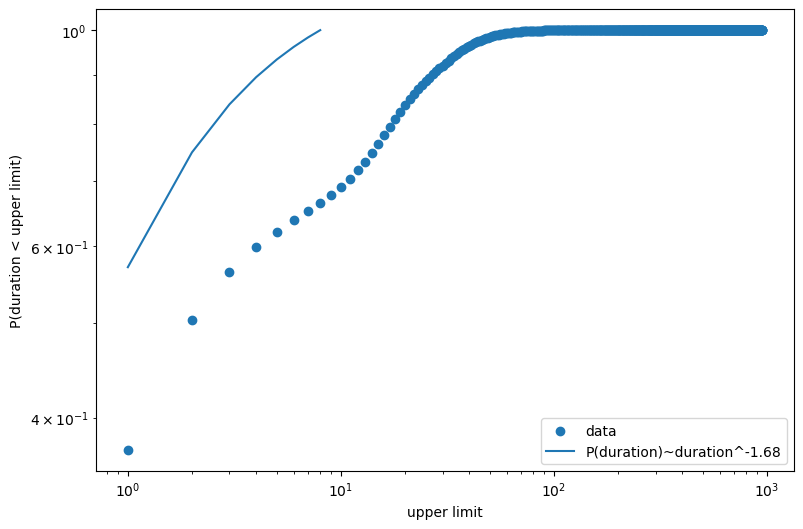

In [43]:
data_cdf = torch.cumsum(data_probs, dim=0)
pl_cdf = torch.cumsum(pl_probs, dim=0)
ks_distance = torch.max( torch.abs(pl_cdf - data_cdf[interval_start:interval_end]) )
print(f'KS distance {ks_distance:.3g}')
make_scatter_and_line_2x(xname=f'upper limit', yname=f'P({value_name} < upper limit)', scatter_label='data', x_scatter_values=values, y_scatter_values=data_cdf, line_label=f'P({value_name})~{value_name}^{exponent_for_pair:.3g}', x_line_values=values_in_range, y_line_values=pl_cdf, do_log_log=True)

sample KS distance 0.000846


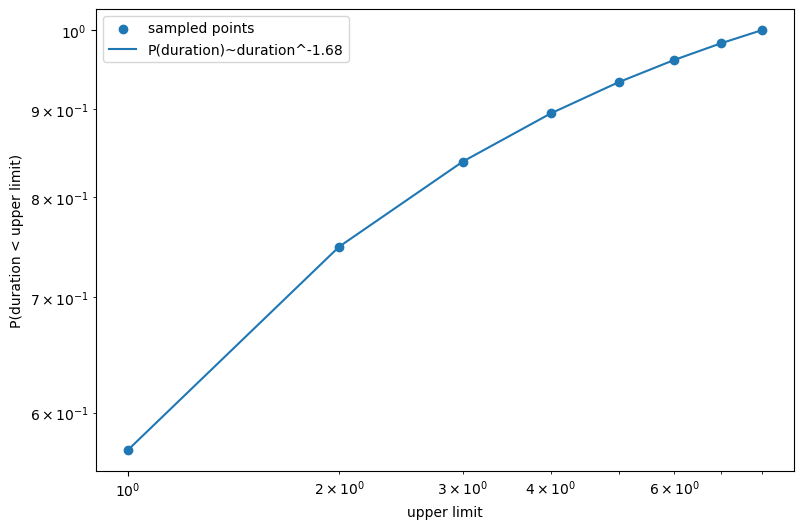

In [44]:
num_points = counts_in_range.sum().round().int()
sample_cdf = torch.count_nonzero( torch.rand( size=(1,num_points), dtype=float_type, device=device ) < pl_cdf.unsqueeze(dim=1), dim=-1 )/num_points
sample_ks_distance = torch.max( torch.abs(pl_cdf - sample_cdf) )
print(f'sample KS distance {sample_ks_distance:.3g}')
make_scatter_and_line_2x(xname=f'upper limit', yname=f'P({value_name} < upper limit)', scatter_label='sampled points', x_scatter_values=values_in_range, y_scatter_values=sample_cdf, line_label=f'P({value_name})~{value_name}^{exponent_for_pair:.3g}', x_line_values=values_in_range, y_line_values=pl_cdf, do_log_log=True)

In [46]:
print( torch.nonzero(interval_starts == 0)[-1] )

tensor([944], device='cuda:0')
